In [1]:
!git clone https://github.com/splendidcomputer/cora_project

Cloning into 'cora_project'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 90 (delta 52), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [22]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from keras.utils import np_utils
from tensorflow.keras.callbacks import Callback
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score


In [3]:
cora = pd.read_csv("./cora_project/cora.content", delimiter="\t", header=None)
y_labels = ["Case_Based", "Genetic_Algorithms", "Neural_Networks", "Probabilistic_Methods", "Reinforcement_Learning", "Rule_Learning", "Theory"]

for i,label in enumerate(y_labels):
    cora[1434][cora[1434]==label] = i

<ipython-input-3-4b8632f12a1b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cora[1434][cora[1434]==label] = i


In [4]:
X = np.asarray(cora.iloc[:,1:-1]).astype('float32')
y = np.asarray(cora.iloc[:,-1]).astype('float32')

In [5]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)


In [39]:
model = Sequential()
model.add(layers.Dense(512, input_shape=(1433,), activation='relu', name="DenseLayer_1"))
model.add(layers.Dense(256, activation='relu', name="DenseLayer_2"))
model.add(layers.Dropout(0.4, name="Dropout_1"))
model.add(layers.Dense(128, activation='relu', name="DenseLayer_3"))
model.add(layers.Dropout(0.4, name="Dropout_2"))
model.add(layers.Dense(64, activation='relu', name="DenseLayer_4"))
model.add(layers.Dense(10, activation='relu', name="DenseLayer_5"))
model.add(layers.Dense(7, activation='softmax', name="OutputLayer"))
# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

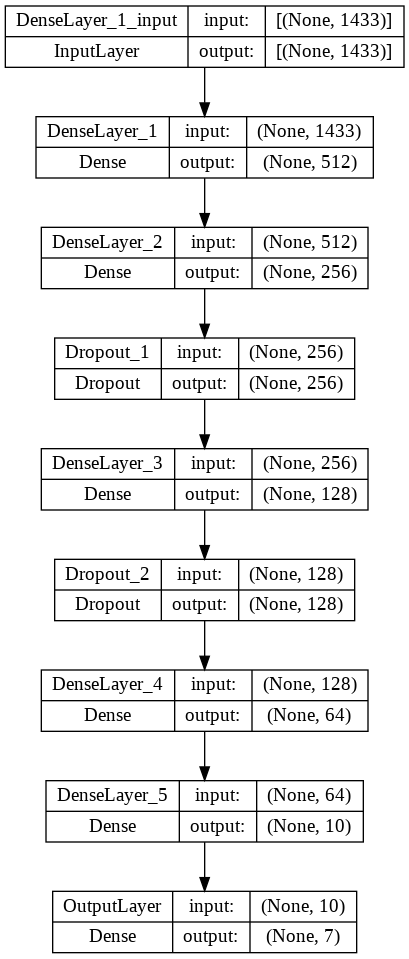

In [40]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
# Implement callback function to stop training
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.95

VALIDATION_ACCURACY_THRESHOLD = 0.75

class myCallback(Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > VALIDATION_ACCURACY_THRESHOLD):   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(VALIDATION_ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

callbacks = myCallback()


In [8]:
kFold = StratifiedKFold(n_splits=10)
# fit the keras model on the dataset
model_score = []
for train, test in kFold.split(X, encoded_Y):
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(encoded_Y)
  model.fit(X[train], dummy_y[train], validation_data=(X[test], dummy_y[test]), epochs=20, batch_size=1, callbacks=[callbacks])
  model_score.append([accuracy_score(encoded_Y[train],np.argmax(model.predict(X[train]), axis=1)), accuracy_score(encoded_Y[test],np.argmax(model.predict(X[test]), axis=1))])


Epoch 1/20
2437/2437 [==============================] - 12s 4ms/step - loss: 1.5369 - accuracy: 0.3984 - val_loss: 1.1050 - val_accuracy: 0.6568
Epoch 2/20
2422/2437 [============================>.] - ETA: 0s - loss: 0.8798 - accuracy: 0.7164
Reached 75.00% accuracy, so stopping training!!
9/9 [==============================] - 0s 2ms/step
Epoch 1/20
2422/2437 [============================>.] - ETA: 0s - loss: 0.4902 - accuracy: 0.8658
Reached 75.00% accuracy, so stopping training!!
9/9 [==============================] - 0s 2ms/step
Epoch 1/20
2420/2437 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.9136
Reached 75.00% accuracy, so stopping training!!
9/9 [==============================] - 0s 2ms/step
Epoch 1/20
2427/2437 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9497
Reached 75.00% accuracy, so stopping training!!
9/9 [==============================] - 0s 2ms/step
Epoch 1/20
2436/2437 [============================>.] - ETA: 0s - l

In [9]:
model_score

[[0.8978251949117768, 0.7638376383763837],
 [0.9343455067706196, 0.8671586715867159],
 [0.9585556011489537, 0.9372693726937269],
 [0.9720968403775133, 0.9704797047970479],
 [0.9856380796060731, 0.981549815498155],
 [0.9909725071809602, 0.996309963099631],
 [0.993434550677062, 1.0],
 [0.9954862535904802, 1.0],
 [0.9967186218211649, 0.9925925925925926],
 [0.9979491386382281, 1.0]]

In [10]:
counter = 0
d = {'Model': [], 'Fold_1': [], 'Fold_2': [], 'Fold_3': [], 'Fold_4': [], 'Fold_5': [], 'Fold_6': [], 'Fold_7': [], 'Fold_8': [], 'Fold_9': [], 'Fold_10': [],'Average': []}
df_test = pd.DataFrame(data=d)
df_train = pd.DataFrame(data=d)

fold_val_score_list_test = ["MLP"]
fold_val_score_list_train = ["MLP"]
for fold_score in model_score:
  fold_val_score_list_test.append(fold_score[1])
  fold_val_score_list_train.append(fold_score[0])
fold_val_score_list_test.append(np.mean(np.array(model_score), axis=0)[1])
fold_val_score_list_train.append(np.mean(np.array(model_score), axis=0)[0])
df_test.loc[len(df_test)] = fold_val_score_list_test
df_train.loc[len(df_train)] = fold_val_score_list_train
counter+=1

In [11]:
df_test

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,Average
0,MLP,0.763838,0.867159,0.937269,0.97048,0.98155,0.99631,1.0,1.0,0.992593,1.0,0.95092


In [12]:
df_train

,Model,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Fold_6,Fold_7,Fold_8,Fold_9,Fold_10,Average
0,MLP,0.897825,0.934346,0.958556,0.972097,0.985638,0.990973,0.993435,0.995486,0.996719,0.997949,0.972302


In [13]:
df_train.to_csv("NN_Train_ACC.tsv", sep="\t")
df_test.to_csv("NN_Test_ACC.tsv", sep="\t")

In [14]:
list_predictions = []
folds_val_acc = []
for train, test in kFold.split(X, encoded_Y):
  fold_predictions = np.argmax(model.predict(X[test]), axis=1)
  list_predictions.append(fold_predictions) 
  dummy_y = np_utils.to_categorical(encoded_Y)
  folds_val_acc.append(model.evaluate(X[test], dummy_y[test]))

9/9 [==============================] - 0s 3ms/step - loss: 0.0166 - accuracy: 1.0000


In [15]:
final_predictions = []
for fold_prediction in list_predictions:
  for item in fold_prediction:
    final_predictions.append(y_labels[item])

In [16]:
final_predictions_array = np.array([cora.iloc[:,0],final_predictions]).T

In [17]:
final_predictions_array

array([['31336', 'Neural_Networks'],
       ['1061127', 'Rule_Learning'],
       ['1106406', 'Reinforcement_Learning'],
       ...,
       ['1128978', 'Genetic_Algorithms'],
       ['117328', 'Case_Based'],
       ['24043', 'Neural_Networks']], dtype='<U22')

In [18]:
list_ids = list(cora.iloc[:,0])

In [19]:
d = {'IDs': list_ids, 'Predictions': final_predictions}
df = pd.DataFrame(data=d)

In [20]:
df.to_csv('final_predictions.tsv', sep="\t")